In [6]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import yaml
from hydra.experimental import compose, initialize_config_module
import hydra
from functools import lru_cache
import torch
from tqdm import tqdm
import json
import faiss
import logging
from collections import defaultdict
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple

from bela.transforms.spm_transform import SPMTransform
from bela.evaluation.model_eval import ModelEval, load_file
# from bela.utils.prediction_utils import get_predictions_using_windows
from bela.utils.analysis_utils import Entity, Sample

logger = logging.getLogger(__name__)
!cat /etc/hostname  # Double check that we are on a gpu node

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
a100-st-p4d24xlarge-9


In [16]:
@dataclass
class GroundTruthEntity:
    offset: int
    length: int
    text: str
    entity_id: str

    @property
    def mention(self):
        return self.text[self.offset : self.offset + self.length]

    def __repr__(self):
        return f"mention=\"{self.mention}\" -> entity_id={self.entity_id}"


@dataclass
class PredictedEntity:
    offset: int
    length: int
    text: str
    entity_id: str
    md_score: float
    el_score: float

    @property
    def mention(self):
        return self.text[self.offset : self.offset + self.length]

    def __repr__(self):
        return f"mention=\"{self.mention}\" -> entity_id={self.entity_id} (md_score={self.md_score:.2f}, el_score={self.el_score:.2f})"


def print_sample(text: str, ground_truth_entities: List[GroundTruthEntity], predicted_entities: List[PredictedEntity], max_display_length=1000):
    print(f"{text[:max_display_length]=}")
    print("***************** Ground truth entities *****************")
    print(f"{len(ground_truth_entities)=}")
    for ground_truth_entity in ground_truth_entities:
        if ground_truth_entity.offset + ground_truth_entity.length > max_display_length:
            continue
        print(ground_truth_entity)
    print("***************** Predicted entities *****************")
    print(f"{len(predicted_entities)=}")
    for predicted_entity in predicted_entities:
        if predicted_entity.offset + predicted_entity.length > max_display_length:
            continue
        print(predicted_entity)


@lru_cache
def get_sp_transform():
    return SPMTransform(max_seq_len=100000)


def get_windows(text, window_length=254, overlap=127):
    sp_transform = get_sp_transform()
    tokens = sp_transform([text])[0]
    tokens = tokens[1:-1]
    windows = []
    for window_start in range(0, len(tokens), window_length - overlap):
        start_pos = tokens[window_start][1]
        if window_start + window_length >= len(tokens):
            end_pos = tokens[-1][2]
        else:
            end_pos = tokens[window_start + window_length][2]
        windows.append((start_pos, end_pos))
    return windows


def convert_predictions_to_dict(example_predictions):
    if len(example_predictions) > 0:
        offsets, lengths, entities, md_scores, el_scores, window_idx = zip(*example_predictions)
    else:
        offsets, lengths, entities, md_scores, el_scores, window_idx = [], [], [], [], [], []
    return {
        "offsets": offsets,
        "lengths": lengths,
        "entities": entities,
        "md_scores": md_scores,
        "el_scores": el_scores,
        "window_idx": window_idx,
    }


def group_predictions_by_example(all_predictions, extended_examples):
    grouped_predictions = defaultdict(list)
    for prediction, extended_example in zip(all_predictions, extended_examples):
        window_start = extended_example["window_start"]
        prediction = dict(prediction)
        prediction["offsets"] = [
            offset + window_start for offset in prediction["offsets"]
        ]
        prediction["window_idx"] = extended_example["window_idx"]
        grouped_predictions[extended_example["document_id"]].append((prediction))

    predictions = {}
    for document_id, example_prediction_list in grouped_predictions.items():
        example_predictions = []
        for prediction in example_prediction_list:
            for offset, length, ent, md_score, el_score in zip(
                prediction["offsets"],
                prediction["lengths"],
                prediction["entities"],
                prediction["md_scores"],
                prediction["el_scores"]
            ):
                example_predictions.append((offset, length, ent, md_score, el_score, prediction["window_idx"]))
                example_predictions = sorted(example_predictions)
        predictions[document_id] = example_predictions

    return predictions


def merge_predictions(example_predictions):
    filtered_example_predictions = []

    current_end = None
    current_offset = None
    current_length = None
    current_ent_id = None
    current_md_score = None
    current_el_score = None
    current_window_idx = None

    for offset, length, ent_id, md_score, el_score, window_idx in example_predictions:
        if current_end is None:
            current_end = offset + length
            current_offset = offset
            current_length = length
            current_ent_id = ent_id
            current_md_score = md_score
            current_el_score = el_score
            current_window_idx = window_idx
            continue

        if offset < current_end:
            # intersection of two predictions
            if md_score > current_md_score:
                current_ent_id = ent_id
                current_offset = offset
                current_length = length
                current_md_score = md_score
                current_el_score = el_score
                current_window_idx = window_idx
        else:
            filtered_example_predictions.append(
                (
                    current_offset,
                    current_length,
                    current_ent_id,
                    current_md_score,
                    current_el_score,
                    current_window_idx,
                )
            )
            current_ent_id = ent_id
            current_offset = offset
            current_length = length
            current_md_score = md_score
            current_el_score = el_score
            current_window_idx = window_idx

        current_end = offset + length

    if current_offset is not None:
        filtered_example_predictions.append(
            (
                current_offset,
                current_length,
                current_ent_id,
                current_md_score,
                current_el_score,
                current_window_idx,
            )
        )

    return filtered_example_predictions


def get_predictions_using_windows(model_eval: ModelEval, test_data, batch_size=1024, window_length=254, window_overlap=127):
    extended_examples = []
    sample_to_window_bound = []
    for example in test_data:
        assert "document_id" in example or "data_example_id" in example
        document_id = example.get("document_id") or example["data_example_id"]
        text = example["original_text"]
        windows = get_windows(text, window_length, window_overlap)
        sample_to_window_bound.append(windows)
        for idx, (start_pos, end_pos) in enumerate(windows):
            new_text = text[start_pos:end_pos]
            extended_examples.append(
                {
                    "document_id": document_id,
                    "original_text": new_text,
                    "gt_entities": example["gt_entities"],
                    "window_idx": idx,
                    "window_start": start_pos,
                    "window_end": end_pos,
                }
            )

    all_predictions = model_eval.get_predictions(
        extended_examples, batch_size=batch_size
    )
    predictions_dict = group_predictions_by_example(all_predictions, extended_examples)

    predictions = []
    for example in test_data:
        assert "document_id" in example or "data_example_id" in example
        document_id = example.get("document_id") or example["data_example_id"]
        text = example["original_text"]
        example_predictions = predictions_dict[document_id]
        example_predictions = merge_predictions(example_predictions)
        example_predictions = convert_predictions_to_dict(example_predictions)
        predictions.append(example_predictions)

    return predictions, sample_to_window_bound

#########################

def safe_division(a, b):
    if b == 0:
        return 0
    else:
        return a / b


def compute_f1_p_r(tp, fp, fn):
    precision = safe_division(tp, (tp + fp))
    recall = safe_division(tp, (tp + fn))
    f1 = safe_division(2 * tp, (2 * tp + fp + fn))
    return f1, precision, recall

def compute_scores(data, predictions, md_threshold=0.2, el_threshold=0.05):
    tp, fp, support = 0, 0, 0
    tp_boe, fp_boe, support_boe = 0, 0, 0

    predictions_per_example = []
    for example, example_predictions in zip(data, predictions):

        example_targets = {
            (offset,length):ent_id
            for _,_,ent_id,_,offset,length in example['gt_entities']
        }

        example_predictions = {
            (offset, length):ent_id
            for offset, length, ent_id, md_score, el_score in zip(
                example_predictions['offsets'],
                example_predictions['lengths'],
                example_predictions['entities'],
                example_predictions['md_scores'],
                example_predictions['el_scores'],
            )
            if (el_score > el_threshold and md_score > md_threshold) 
        }

        predictions_per_example.append((len(example_targets), len(example_predictions)))

        for pos, ent in example_targets.items():
            support += 1
            if pos in example_predictions and example_predictions[pos] == ent:
                tp += 1
        for pos, ent in example_predictions.items():
            if pos not in example_targets or example_targets[pos] != ent:
                fp += 1

        example_targets_set = set(example_targets.values())
        example_predictions_set = set(example_predictions.values())

        for ent in example_targets_set:
            support_boe += 1
            if ent in example_predictions_set:
                tp_boe += 1
        for ent in example_predictions_set:
            if ent not in example_targets_set:
                fp_boe += 1

    fn = support - tp
    fn_boe = support_boe - tp_boe
    return compute_f1_p_r(tp, fp, fn), compute_f1_p_r(tp_boe, fp_boe, fn_boe)


def compute_md_scores(data, predictions, sample_to_window_bound, md_threshold=0.2, only_preds_of_window = None, debug_samples=0):
    tp, fp, support = 0, 0, 0
    num_preds = 0

    predictions_per_example = []
    for i, (example, example_predictions, window_bounds) in enumerate(zip(data, predictions, sample_to_window_bound)):
        if i < debug_samples:
            predicted_entities = [Entity(offset=offset, length=length, text=text, entity_id=entity_id, md_score=md_score, el_score=el_score) 
                                for offset, length, entity_id, md_score, el_score in 
                              zip(example_predictions["offsets"], example_predictions["lengths"], example_predictions["entities"], example_predictions["md_scores"], example_predictions["el_scores"])]
            Sample(text=example["original_text"], predicted_entities=predicted_entities).print()

        if only_preds_of_window is not None and len(window_bounds)>only_preds_of_window:
            window_start, window_end = window_bounds[only_preds_of_window]
        else:
             window_start, window_end = (0,0)
                
        example_targets = {
            (offset,length):ent_id
            for _,_,ent_id,_,offset,length in example['gt_entities']
            if (only_preds_of_window is None or (offset>= window_start and offset< window_end))
            
        }
                    

        example_predictions = {
            (offset, length):ent_id
            for offset, length, ent_id, md_score, window_idx in zip(
                example_predictions['offsets'],
                example_predictions['lengths'],
                example_predictions['entities'],
                example_predictions['md_scores'],
                example_predictions['window_idx'],
            )
            if ((md_score > md_threshold) and ( only_preds_of_window is None or window_idx == only_preds_of_window))
        }

        predictions_per_example.append((len(example_targets), len(example_predictions)))

        for pos in example_targets.keys():
            support += 1
            if pos in example_predictions:
                tp += 1
        for pos in example_predictions.keys():
            if pos not in example_targets:
                fp += 1

    fn = support - tp
    return (*compute_f1_p_r(tp, fp, fn), support, sum([x[1] for x in predictions_per_example]))


def correct_mention_offsets(example_predictions, text):
    TEXT_SEPARATORS = [' ','.',',','!','?','-','\n']
    corrected_example_predictions = []
    for offset,length,ent_id,md_score,el_score in example_predictions:
        while offset !=0 and offset<len(text) and (text[offset-1] not in TEXT_SEPARATORS or text[offset] in TEXT_SEPARATORS):
            offset += 1
            length -= 1
        while offset+length < len(text) and text[offset+length] not in TEXT_SEPARATORS:
            length += 1
        corrected_example_predictions.append((
            offset,length,ent_id,md_score,el_score
        ))
    return corrected_example_predictions

"""
def get_predictions_using_windows(test_data, batch_size=1024):
    extended_examples = []

    for example in test_data:
        text = example['original_text']
        windows = get_windows(text)
        for idx, (start_pos, end_pos) in enumerate(windows):
            new_text = text[start_pos:end_pos]
            extended_examples.append({
                'document_id': example['document_id'] if 'document_id' in example else example['data_example_id'],
                'original_text': new_text,
                'gt_entities': example['gt_entities'],
                'window_idx': idx,
                'window_start': start_pos,
                'window_end': end_pos,
            })

    all_predictions = model_eval.get_predictions(extended_examples, batch_size=batch_size)
    predictions_dict = group_predictions_by_example(all_predictions, extended_examples)

    predictions = []
    for example in test_data:
        document_id = example['document_id']  if 'document_id' in example else example['data_example_id']
        text = example['original_text']
        example_predictions = predictions_dict[document_id]
        example_predictions = merge_predictions(example_predictions)
        example_predictions = correct_mention_offsets(example_predictions, text)
        example_predictions = convert_predictions_to_dict(example_predictions)
        predictions.append(example_predictions)

    return predictions
"""

def shift_shift(text):
    for idx,ch in enumerate(text):
        if not ch.isalpha():
            return idx

def convert_data_for_disambiguation(data, lang):
    # convert examples to 1 entity per example and shift if needed
    if lang=='ar':
        MAX_LENGTH = 600
        MAX_OFFSET = 400
    elif lang == 'ja':
        MAX_LENGTH = 350
        MAX_OFFSET = 250
    else:
        MAX_LENGTH = 800
        MAX_OFFSET = 600
    new_examples = []
    for example in tqdm(data):
        original_text = example['original_text']
        for _, _, ent, _, offset, length in example['gt_entities']:
            shift = 0
            if len(original_text) > MAX_LENGTH and offset > MAX_OFFSET:
                shift = (offset - MAX_OFFSET)
                shift += shift_shift(original_text[shift:])
            new_example = {
                'original_text': original_text[shift:],
                'gt_entities': [[0,0,ent,_,offset-shift,length]],
            }
            new_examples.append(new_example)
    return new_examples


def metrics_disambiguation(test_data, predictions):
    support = 0
    support_only_predicted = 0
    correct = 0
    incorrect_pos = 0

    for example_idx, (example, prediction) in tqdm(enumerate(zip(test_data, predictions))):
#         targets = {
#             (offset,length):ent_id
#             for _,_,ent_id,_,offset,length in example['gt_entities']
#         }
#         prediction = {
#             (offset,length):ent_id
#             for offset,length,ent_id in zip(prediction['offsets'], prediction['lengths'], prediction['entities'])
#         }

#         support += len(targets)
#         support_only_predicted += len(prediction)
        
#         correct += sum(1 for pos,ent_id in prediction.items() if (pos in targets and targets[pos] == ent_id))
#         incorrect_pos += sum(1 for pos,_ in prediction.items() if pos not in targets)
        if len(prediction['entities']) == 0:
            continue
        target = example['gt_entities'][0][2]
        prediction = prediction['entities'][0]
        correct += (target == prediction)
        support += 1

    accuracy = correct/support
    # accuracy_only_predicted = correct/support_only_predicted

    return accuracy, support #, accuracy_only_predicted, support_only_predicted

# Load model

In [3]:
%%prun -s tottime -l 10

# e2e model with isotropic embeddings
#checkpoint_path = '/checkpoints/movb/bela/2023-01-13-023711/0/lightning_logs/version_4144/checkpoints/last.ckpt'  # Not working: Unexpected key(s) in state_dict: "saliency_encoder.mlp.0.weight", "saliency_encoder.mlp.0.bias", "saliency_encoder.mlp.3.weight", "saliency_encoder.mlp.3.bias", "saliency_encoder.mlp.6.weight", "saliency_encoder.mlp.6.bias". 
#checkpoint_path = '/checkpoints/movb/bela/2022-11-27-225013/0/lightning_logs/version_286287/checkpoints/last_15000.ckpt'  # Works but 0 F1

# E2E checkpoint with new embeddings
# https://fb.quip.com/QVUxA4UcAZ7k#temp:C:OcG977f71fab43d42379521a0dff
# Works but give 0 F1 on tackbp (mention detection is okish, but entity disambiguation is random)
#checkpoint_path = '/checkpoints/movb/bela/2023-01-18-220105/0/lightning_logs/version_4820/checkpoints/last.ckpt'
checkpoint_path = '/checkpoints/movb/bela/2023-02-15-200343/0/lightning_logs/version_127953/checkpoints/checkpoint_9.ckpt'
#model_eval = ModelEval(checkpoint_path, config_name="joint_el_mel_new")
model_eval = ModelEval(checkpoint_path, config_name="joint_el_mel_new_index")

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


         35247279 function calls (35184412 primitive calls) in 52.815 seconds

   Ordered by: internal time
   List reduced from 6673 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       34   12.711    0.374   12.713    0.374 serialization.py:1076(load_tensor)
        1   10.844   10.844   11.923   11.923 joint_el_datamodule.py:21(__init__)
        1    6.706    6.706    6.706    6.706 {built-in method faiss._swigfaiss.GpuIndexFlat_add}
        1    3.542    3.542    3.542    3.542 {built-in method faiss._swigfaiss.new_GpuIndexFlatIP}
        1    2.720    2.720   52.819   52.819 model_eval.py:61(__init__)
      302    2.086    0.007    2.086    0.007 {method 'uniform_' of 'torch._C._TensorBase' objects}
        4    1.861    0.465    1.861    0.465 {method 'normal_' of 'torch._C._TensorBase' objects}
     1351    1.643    0.001    1.643    0.001 {built-in method io.open_code}
     8761    1.581    0.000    1.581    0.000 {built-

In [4]:
# Set low thresholds
model_eval.task.md_threshold = 0.01
model_eval.task.el_threshold = 0.01

# End-to-end Eval

In [ ]:
print(f"{model_eval.checkpoint_path=}")
print(f"{model_eval.task.md_threshold=}")
print(f"{model_eval.task.el_threshold=}")
datasets = [
    "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl",
    #'/fsx/movb/data/matcha/mewsli-9/ta.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/ar.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/en.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/fa.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/sr.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/tr.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/de.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/es.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/ja.jsonl',
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    test_data = load_file(test_data_path)
    #test_data = test_data[:1000]
    
    predictions = get_predictions_using_windows(model_eval, test_data)
    (f1, precision, recall), (f1_boe, precision_boe, recall_boe) = ModelEval.compute_scores(test_data, predictions)
    
    print(f"F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")
    print(f"F1 boe = {f1_boe:.4f}, precision = {precision_boe:.4f}, recall = {recall_boe:.4f}")

# Disambiguation Eval

In [ ]:

def shift_shift(text):
    for idx,ch in enumerate(text):
        if not ch.isalpha():
            return idx

def convert_data_for_disambiguation(data, lang):
    # convert examples to 1 entity per example and shift if needed
    if lang=='ar':
        MAX_LENGTH = 600
        MAX_OFFSET = 400
    elif lang == 'ja':
        MAX_LENGTH = 350
        MAX_OFFSET = 250
    else:
        MAX_LENGTH = 800
        MAX_OFFSET = 600
    new_examples = []
    for example in tqdm(data):
        original_text = example['original_text']
        for _, _, ent, _, offset, length in example['gt_entities']:
            shift = 0
            if len(original_text) > MAX_LENGTH and offset > MAX_OFFSET:
                shift = (offset - MAX_OFFSET)
                shift += shift_shift(original_text[shift:])
            new_example = {
                'original_text': original_text[shift:],
                'gt_entities': [[0,0,ent,_,offset-shift,length]],
            }
            new_examples.append(new_example)
    return new_examples


def metrics_disambiguation(test_data, predictions):
    support = 0
    support_only_predicted = 0
    correct = 0
    incorrect_pos = 0

    for example_idx, (example, prediction) in tqdm(enumerate(zip(test_data, predictions))):
#         targets = {
#             (offset,length):ent_id
#             for _,_,ent_id,_,offset,length in example['gt_entities']
#         }
#         prediction = {
#             (offset,length):ent_id
#             for offset,length,ent_id in zip(prediction['offsets'], prediction['lengths'], prediction['entities'])
#         }

#         support += len(targets)
#         support_only_predicted += len(prediction)
        
#         correct += sum(1 for pos,ent_id in prediction.items() if (pos in targets and targets[pos] == ent_id))
#         incorrect_pos += sum(1 for pos,_ in prediction.items() if pos not in targets)
        if len(prediction['entities']) == 0:
            continue
        target = example['gt_entities'][0][2]
        prediction = prediction['entities'][0]
        correct += (target == prediction)
        support += 1

    accuracy = correct/support
    # accuracy_only_predicted = correct/support_only_predicted

    return accuracy, support #, accuracy_only_predicted, support_only_predicted

In [ ]:
datasets = [
    '/fsx/movb/data/matcha/mewsli-9/ta.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/ar.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/en.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/fa.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/sr.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/tr.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/de.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/es.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/ja.jsonl',
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    lang = test_data_path[-8:-6]
    test_data = load_file(test_data_path)
    test_data = convert_data_for_disambiguation(test_data[:10000], lang)
    predictions = model_eval.get_disambiguation_predictions(test_data)
    accuracy, support = metrics_disambiguation(test_data, predictions)
    print(f"Accuracty {accuracy}, support {support}")

# Mention Detection Eval

In [18]:
model_eval.task.md_threshold = 0.2
model_eval.task.el_threshold = 0.0
print(f"{model_eval.checkpoint_path=}")
print(f"{model_eval.task.md_threshold=}")
print(f"{model_eval.task.el_threshold=}")
datasets = [
    # "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl",
    '/fsx/movb/data/matcha/mel/test.1st.txt'
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    test_data = load_file(test_data_path)
    # test_data = test_data[:100]
    
    predictions, sample_to_window_bound = get_predictions_using_windows(model_eval, test_data)
    for w in range(0, 10):
        (f1, precision, recall, support, num_preds) = compute_md_scores(test_data, predictions, sample_to_window_bound, only_preds_of_window=w)
        print(f"Window={w} F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}, support={support}, num_preds={num_preds}")
    (f1, precision, recall, support, num_preds) = compute_md_scores(test_data, predictions, sample_to_window_bound)
    print(f"Window=ALL F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}, support={support}, num_preds={num_preds}")

model_eval.checkpoint_path='/checkpoints/movb/bela/2023-02-15-200343/0/lightning_logs/version_127953/checkpoints/checkpoint_9.ckpt'
model_eval.task.md_threshold=0.2
model_eval.task.el_threshold=0.0
Processing /fsx/movb/data/matcha/mel/test.1st.txt


42902it [00:01, 31356.55it/s]
100%|██████████| 58/58 [16:50<00:00, 17.42s/it]


Window=0 F1 = 0.5719, precision = 0.6560, recall = 0.5068, support=233693, num_preds=180558
Window=1 F1 = 0.3246, precision = 0.3870, recall = 0.2796, support=34255, num_preds=24745
Window=2 F1 = 0.3529, precision = 0.3668, recall = 0.3400, support=11890, num_preds=11021
Window=3 F1 = 0.2593, precision = 0.2665, recall = 0.2525, support=3944, num_preds=3738
Window=4 F1 = 0.3119, precision = 0.3446, recall = 0.2849, support=860, num_preds=711
Window=5 F1 = 0.5386, precision = 0.6789, recall = 0.4464, support=289, num_preds=190
Window=6 F1 = 0.5648, precision = 0.6391, recall = 0.5060, support=168, num_preds=133
Window=7 F1 = 0.5318, precision = 0.5412, recall = 0.5227, support=88, num_preds=85
Window=8 F1 = 0.3750, precision = 0.3600, recall = 0.3913, support=23, num_preds=25
Window=9 F1 = 0.1600, precision = 0.1333, recall = 0.2000, support=10, num_preds=15
Window=ALL F1 = 0.5711, precision = 0.6038, recall = 0.5419, support=246524, num_preds=221243


In [11]:
sum([1 for p in predictions ]

0

# Rejection head ablation study

Processing /fsx/movb/data/matcha/mel/test.1st.txt


42902it [00:01, 24811.10it/s]


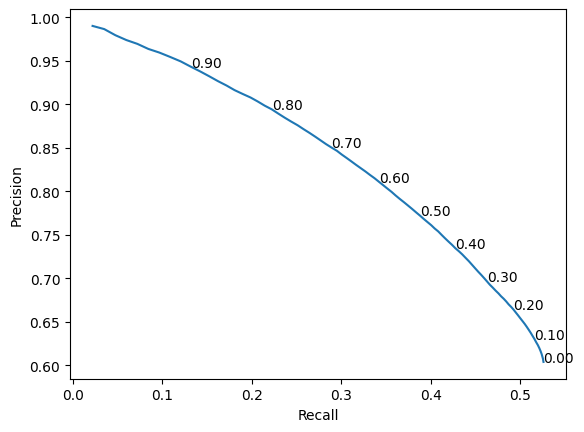

In [20]:
import matplotlib.pyplot as plt
import numpy as np


model_eval.task.md_threshold = 0.05
model_eval.task.el_threshold = 0.00
datasets = [
    # "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl",
    '/fsx/movb/data/matcha/mel/test.1st.txt'
    #'/fsx/movb/data/matcha/mewsli-9/en.jsonl',
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    test_data = load_file(test_data_path)
    #test_data = test_data[:1000]
    
    predictions, sample_to_window_bound = get_predictions_using_windows(model_eval, test_data)
    
    """
    (f1, precision, recall), (f1_boe, precision_boe, recall_boe) = compute_scores(test_data, predictions, el_threshold=0.5)
    print(f"F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")
    print(f"F1 boe = {f1_boe:.4f}, precision = {precision_boe:.4f}, recall = {recall_boe:.4f}")
    
    print(f"Without rejection head")
    (f1, precision, recall), (f1_boe, precision_boe, recall_boe) = compute_scores(test_data, predictions, el_threshold=0.0)
    print(f"F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")
    print(f"F1 boe = {f1_boe:.4f}, precision = {precision_boe:.4f}, recall = {recall_boe:.4f}")
    """
    
    el_thresholds = np.arange(0.0, 1.0, 0.01)
    precision = []
    recall = []
    for el_threshold in el_thresholds:
        _, (_, precision_boe, recall_boe) = compute_scores(test_data, predictions, el_threshold=el_threshold)
        precision.append(precision_boe)
        recall.append(recall_boe)
        
    plt.plot(recall, precision)
    for x,y, th in zip(recall[::10], precision[::10], el_thresholds[::10]): 
        plt.text(x, y, f'{th:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    

In [ ]:
sum([len(e['gt_entities']) for e in test_data])

# Inference time

In [ ]:
def batch_samples(samples, batch_size):
    # Yield batches of samples
    for i in range(0, len(samples), batch_size):
        yield samples[i : i + batch_size]


texts = [sample["original_text"] for sample in load_file("/fsx/movb/data/matcha/mewsli-9/en.jsonl")]
batch_size = 1024
print(f"Processing {len(texts)} texts, {batch_size=}, {model_eval.transform.max_seq_len=}")
%time _ = [model_eval.process_batch(batch_texts) for batch_texts in tqdm(batch_samples(texts, batch_size), desc="Inference")]

## Eyeball Samples

In [ ]:
text = "Taylor Swift lives in New York City. New York City is a city in the United States."
prediction = model_eval.process_batch([text])[0]
predicted_entities = [PredictedEntity(offset, length, text, entity_id, md_score, el_score) for offset, length, entity_id, md_score, el_score in zip(prediction["offsets"], prediction["lengths"], prediction["entities"], prediction["md_scores"], prediction["el_scores"])]
print_sample(text, [], predicted_entities)

In [ ]:

test_data_path = "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl"
print(f"Processing {test_data_path}")
test_data = load_file(test_data_path)
sample = test_data[200]
prediction = get_predictions_using_windows(model_eval, [sample])[0]
text = sample["original_text"]
max_length = 1024

ground_truth_entities = [GroundTruthEntity(offset, length, text, entity_id) for _, _, entity_id, _, offset, length in sample["gt_entities"]]
predicted_entities = [PredictedEntity(offset, length, text, entity_id, md_score, el_score) for offset, length, entity_id, md_score, el_score in zip(prediction["offsets"], prediction["lengths"], prediction["entities"], prediction["md_scores"], prediction["el_scores"])]
print_sample(text, ground_truth_entities, predicted_entities, max_display_length=1000)

# Draft